# Behold Technical Test

We will primarily be using the fast.ai library built on top of pytorch. This script should be used on a machine with a GPU.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

In [16]:
# A new version of PyTorch as been very recently released triggering a bunch of deprecation warnings.
# We will just turn them off for the time being until the fastai codebase gets updated to use Pytorch 1.4.0
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
path = Path('/home/jupyter/tutorials/data/behold')

## Preprocessing

Let's take a look at the the csv file containing our labels. 

In [5]:
df = pd.read_csv(path/'behold_coding_challenge_train.csv',index_col=0)

In [6]:
print(len(df))
df.head()

8542


,ID,epidural,intraparenchymal,subarachnoid
0,train_0,1,0,1
1,train_1,1,0,0
2,train_2,1,0,1
3,train_3,1,0,1
4,train_4,1,0,0


Let's modify it to get it into the format that we need for multilabel classification. We will concatenate all the labels into a new feature. Any instances which don't have any labels will be labelled as `normal` yielded us 4 different labels.

In [7]:
df.loc[df.epidural == 1, 'epidural'] = "epidural"
df.loc[df.intraparenchymal == 1, 'intraparenchymal'] = "intraparenchymal"
df.loc[df.subarachnoid == 1, 'subarachnoid'] = "subarachnoid"
df = df.replace(0, "")

In [8]:
df['tag'] = df['epidural'].astype(str) + " " + df['intraparenchymal'] + " " + df['subarachnoid']
df.tag = df.tag.str.strip()
df = df.drop(columns=['epidural', 'intraparenchymal', 'subarachnoid'])
df.tag = df.tag.replace("", "normal")
df

,ID,tag
0,train_0,epidural subarachnoid
1,train_1,epidural
2,train_2,epidural subarachnoid
3,train_3,epidural subarachnoid
4,train_4,epidural
...,...,...
8588,train_8588,normal
8589,train_8589,normal
8590,train_8590,normal
8591,train_8591,normal


Let's save this as a new csv file and use it to label our images when we create a `DataBunch`.

In [9]:
df.to_csv(path/"labels.csv",index=False)

In [10]:
df = pd.read_csv(path/'labels.csv')
df

,ID,tag
0,train_0,epidural subarachnoid
1,train_1,epidural
2,train_2,epidural subarachnoid
3,train_3,epidural subarachnoid
4,train_4,epidural
...,...,...
8537,train_8588,normal
8538,train_8589,normal
8539,train_8590,normal
8540,train_8591,normal


Here we set up our `DataBunch` using the `ImageList` API. We take the labels from our new csv file and allocate 20% of our training data to be validation data. We also define an image transformation function for performing data augmentation and normalize our data to have the same stats as ImageNet as we will be initially using models pretrained on ImageNet. Lastly, we set our image size to 128 x 128. All of our images are this size ensuring which makes things easier and ensures we are using every pixel.

Having looked at the images we have been given, it is clear they are not very uniform, the head can pointed in any direction and is often not in the centre of the image. Furthermore, the image is often quite zoomed out with a lot of blackspace around the edges. For these reasons, we will ensure our augmentation flips the images in all directions and zooms up to 20%.

In [26]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.2, max_warp=0.)

In [27]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'labels.csv', folder='train_images', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
       .add_test_folder(path/'test_images'))

In [28]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

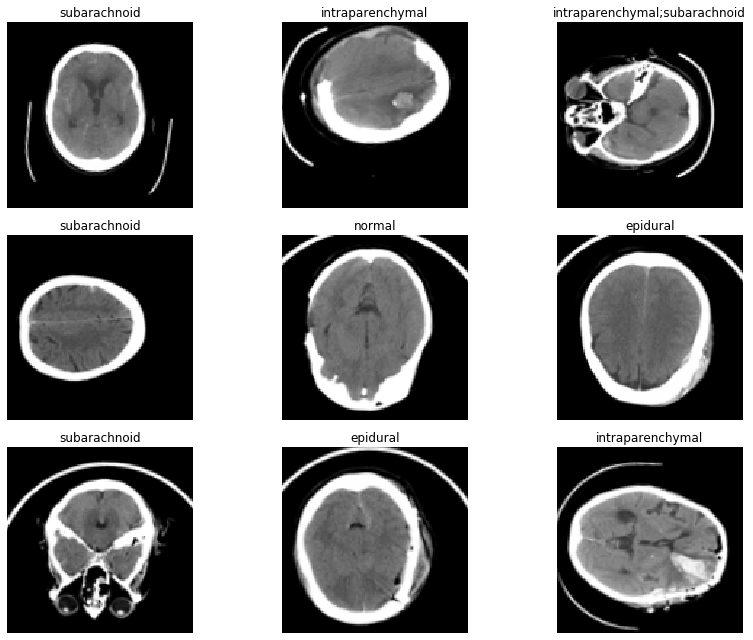

In [29]:
data.show_batch(rows=3, figsize=(12,9))

Everything looks good, let's move on to training our first model.

## Training

### Resnet34 prototype

In [37]:
defaults.device = torch.device('cuda')

In [31]:
arch = models.resnet34

In [32]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


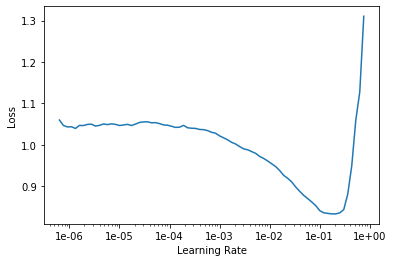

In [34]:
learn.recorder.plot()

Then we can fit the head of our network.

In [35]:
lr = 0.02

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1-rn34')

## Inference

In [ ]:
defaults.device = torch.device('cpu')